## 0 Imports and Constants

In [1]:
## 0 Imports and Constants
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../../'))
sys.path.insert(0, parent_dir)
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import seaborn as sns
from torch.utils.data import DataLoader
from copy import deepcopy as dc

from utilities import split_data_into_sequences, load_sequential_time_series, reconstruct_sequential_data, Scaler, extract_features_and_targets_clas, train_test_split, accuracy
from data_evaluation.visual.visual_evaluation import visual_evaluation
from data_evaluation.predictive.predictive_evaluation import predictive_evaluation
from data_evaluation.discriminative.discriminative_model import LSTMClassification, CNNClassification, train_cnn
from predictive.LSTM import train_model
from predictive.TimeSeriesDataset import TimeSeriesDataset

DATA_FOLDER = Path("../../data")
REAL_DATA_FOLDER = DATA_FOLDER / "real"
SYNTHETIC_DATA_FOLDER = DATA_FOLDER / "synthetic"

In [2]:
MODEL = "lstm"

if MODEL == "lstm":
    hyperparameters = {
        "lr": 0.0001,
        "batch_size": 32,
        "hidden_size": 4,
        "num_layers": 2,
        "bidirectional": True,
        "output_logits": True,
        "num_epochs": 10000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

elif MODEL == "cnn":
    hyperparameters = {
        "lr": 0.00001,
        "batch_size": 32,
        "num_epochs": 1000,
        "device": 'cuda' if torch.cuda.is_available() else 'cpu'
    }

## 1 Loading Data

In [3]:
data = load_sequential_time_series(SYNTHETIC_DATA_FOLDER / 'discriminative_train' / 'discriminative_train_57000_13_5.csv', shape=(57000, 13, 5))

In [4]:
train, val = train_test_split(data, split_ratio=0.9)

In [5]:
X_batch_train, y_batch_train, X_batch_val, y_batch_val = extract_features_and_targets_clas(train, val)

Extracted features and target from training and test data.
Shape of X_train: (51300, 12, 5)
Shape of y_train: (51300, 1)
Shape of X_test: (5700, 12, 5)
Shape of y_test: (5700, 1)


In [6]:
# Depending on the type of the used scaler, targets could be messed up
# Thererfore, we need to scale data after splitting into features and targets
scaler = Scaler(X_batch_train)

In [7]:
X_batch_train = scaler.scale_data(X_batch_train)
X_batch_val = scaler.scale_data(X_batch_val)

In [8]:
# put data on tensors (since they had to be numpy arrays for the scaler)
X_batch_train = torch.tensor(X_batch_train, dtype=torch.float32)
y_batch_train = torch.tensor(y_batch_train, dtype=torch.float32)
X_batch_val = torch.tensor(X_batch_val, dtype=torch.float32)
y_batch_val = torch.tensor(y_batch_val, dtype=torch.float32)

In [9]:
train_dataset = TimeSeriesDataset(X_batch_train, y_batch_train)
val_dataset = TimeSeriesDataset(X_batch_val, y_batch_val)

train_loader = DataLoader(train_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=hyperparameters["batch_size"], shuffle=False)

## 2 Training the model

In [10]:
criterion = nn.BCEWithLogitsLoss()

In [11]:
val_losses = []
val_accs = []
train_losses = []
train_accs = []

In [12]:
if MODEL == 'lstm':

    print("Training LSTM model...")

    model_path = f"models/{MODEL}_checkpoint.pth"

    model = LSTMClassification(
        device=hyperparameters["device"],
        batch_size=hyperparameters["batch_size"],
        input_size=X_batch_train.shape[2],
        hidden_size=hyperparameters["hidden_size"],
        num_stacked_layers=hyperparameters["num_layers"],
        bidirectional=hyperparameters["bidirectional"],
        output_logits=hyperparameters["output_logits"]
    )

    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters["lr"])

    train_losses, train_accs, val_losses, val_accs, model = train_model(
                        model=model,
                        train_loader=train_loader,
                        val_loader=val_loader,
                        criterion=criterion,
                        optimizer=optimizer,
                        device=hyperparameters["device"],
                        num_epochs=hyperparameters["num_epochs"],
                        verbose=True,
                        save_path=model_path)
    
elif MODEL == 'cnn':

    print("Training CNN model...")
    
    model = CNNClassification(verbose=False)
    optimizer = torch.optim.Adam(model.parameters(), lr=hyperparameters['lr'])

    train_losses, val_losses, train_accs, val_accs, model = train_cnn(
        model=model,
        hyperparameters=hyperparameters,
        train_loader=train_loader,
        val_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
    )

Training LSTM model...
Epoch: 1
Train Loss: 0.6937420777326213 // Train Acc: 50.02532730673317
Val Loss: 0.6931093391759435 // Val Acc: 50.017458100558656
**************************************************
Epoch: 11
Train Loss: 0.6925413353261805 // Train Acc: 52.19957917705736
Val Loss: 0.6926001693283379 // Val Acc: 51.7981843575419
**************************************************
Epoch: 21
Train Loss: 0.6869101705322241 // Train Acc: 54.79465399002494
Val Loss: 0.6880947324816741 // Val Acc: 54.29469273743017
**************************************************
Epoch: 31
Train Loss: 0.6819994758786704 // Train Acc: 56.631857855361595
Val Loss: 0.6843510113614898 // Val Acc: 55.42946927374302
**************************************************
Epoch: 41
Train Loss: 0.6777443614163601 // Train Acc: 57.84367206982544
Val Loss: 0.6810426478945343 // Val Acc: 56.25
**************************************************
Epoch: 51
Train Loss: 0.6700941661275236 // Train Acc: 59.131468204488776


## 3 Evaluate Training

Text(0.5, 1.0, 'Validation Accuracy')

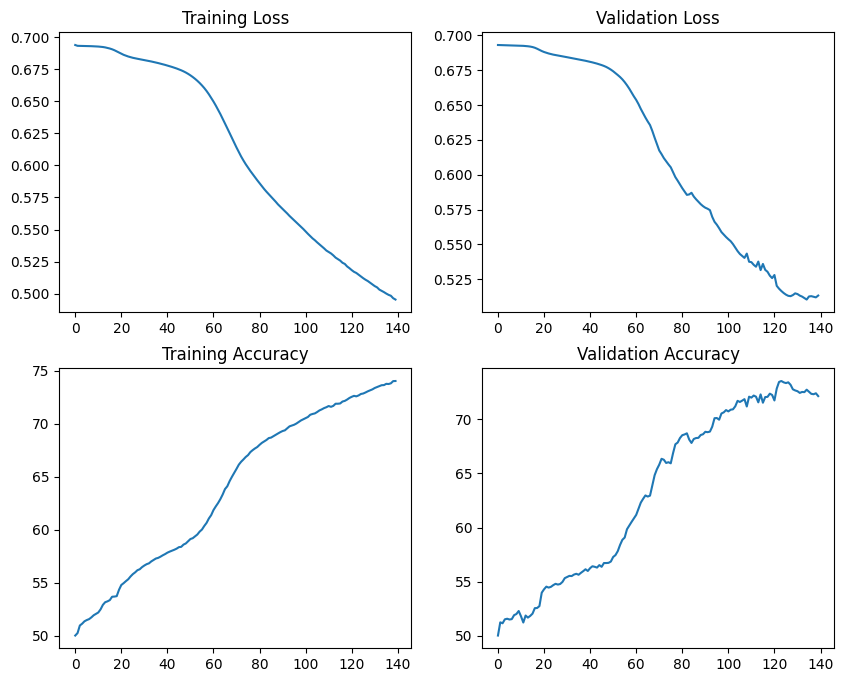

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Diagramm 1 (oben links)
axs[0, 0].plot(train_losses, label="BCELoss")
axs[0, 0].set_title('Training Loss')

axs[0, 1].plot(val_losses, label="BCELoss")
axs[0, 1].set_title('Validation Loss')

axs[1, 0].plot(train_accs, label="Accuracy")
axs[1, 0].set_title('Training Accuracy')

axs[1, 1].plot(val_accs, label="Accuracy")
axs[1, 1].set_title('Validation Accuracy')

In [16]:
no, seq, dim = (4750, 13, 5)
autoencoder_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / '3_Autoencoder' / 'discriminative_test_lstm_autoencoder_15_4750_13_5.csv', shape=(no, seq, dim))
vae_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / '4_Variational_Autoencoder' / 'discriminative_test_fc_vae_pt_4750_13_5.csv', shape=(no, seq, dim))
jitter_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / '1_Jittering' / 'discriminative_test_jitter_01_4750_13_5.csv', shape=(no, seq, dim))
timegan_gru_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / '6_TimeGAN_GRU' / 'discriminative_test_timegan_gru_4750_13_5.csv', shape=(no, seq, dim))
timegan_lstm_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / '5_TimeGAN_LSTM' / 'discriminative_test_timegan_lstm_4750_13_5.csv', shape=(no, seq, dim))
timewarp_test = load_sequential_time_series(DATA_FOLDER / 'evaluation_data' / '2_Timewarping' / 'discriminative_test_timewarp_4750_13_5.csv', shape=(no, seq, dim))

In [17]:
results = pd.DataFrame(columns=['Method', 'Accuracy'])

In [18]:
def get_discriminative_test_performance(model, test_data, method, results):

    X_test, y_test = extract_features_and_targets_clas(test_data)
    X_test = scaler.scale_data(X_test)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    with torch.inference_mode(): 
        test_logits = model(X_test.to(hyperparameters['device'])) # get plain model output (logits)
        test_probs = torch.sigmoid(test_logits) # get probabilities
        test_preds = torch.round(test_probs) # get classes

        test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
        print(test_acc)
        
        results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)

    return results

In [19]:
if MODEL == 'lstm':
    test_model = LSTMClassification(
        device=hyperparameters["device"],
        batch_size=hyperparameters["batch_size"],
        input_size=X_batch_train.shape[2],
        hidden_size=hyperparameters["hidden_size"],
        num_stacked_layers=hyperparameters["num_layers"],
        bidirectional=hyperparameters["bidirectional"],
        output_logits=hyperparameters["output_logits"]
    )
elif MODEL == 'cnn':
    test_model = CNNClassification(verbose=False)

test_model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [20]:
X_test, y_test = extract_features_and_targets_clas(autoencoder_test)
X_test = scaler.scale_data(X_test)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

with torch.inference_mode(): 
    test_logits = test_model(X_test.to(hyperparameters['device'])) # get plain model output (logits)
    test_probs = torch.sigmoid(test_logits) # get probabilities
    test_preds = torch.round(test_probs) # get classes
    test_preds = test_preds.clone().detach()

    test_acc = accuracy(y_true=y_test, y_pred=test_preds)
    print(f'Test Accuracy: {test_acc}')

Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
Test Accuracy: 69.17894736842105


In [21]:
results = get_discriminative_test_performance(test_model, autoencoder_test, 'Autoencoder', results)
results = get_discriminative_test_performance(test_model, vae_test, 'Variational Autoencoder', results)
results = get_discriminative_test_performance(test_model, jitter_test, 'Jitter', results)
results = get_discriminative_test_performance(test_model, timegan_gru_test, 'TimeGAN GRU', results)
results = get_discriminative_test_performance(test_model, timegan_lstm_test, 'TimeGAN LSTM', results)
results = get_discriminative_test_performance(test_model, timewarp_test, 'Timewarp', results)

Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
69.17894736842105
Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
94.94736842105263
Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
83.6
Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
72.21052631578947
Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
88.63157894736841
Extracted features and target from training data.
Shape of X_train: (4750, 12, 5)
Shape of y_train: (4750, 1)
38.126315789473686


/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_94184/3364649101.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_acc = accuracy(y_true=y_test, y_pred=torch.tensor(test_preds))
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_94184/3364649101.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([{'Method': method, 'Accuracy': test_acc}])], ignore_index=True)
/var/folders/hg/9qymy01n6cnff41vb6p0yj_80000gn/T/ipykernel_94184/3364649101.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTens

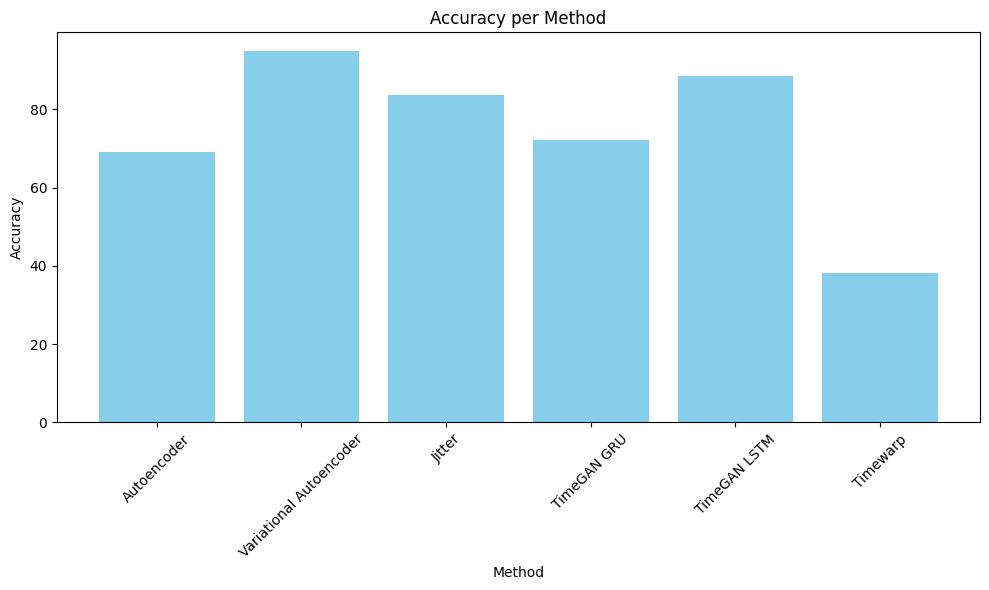

In [22]:
plt.figure(figsize=(10, 6))
plt.bar(results['Method'], results['Accuracy'], color='skyblue')

# Diagramm anpassen
plt.xlabel('Method')
plt.ylabel('Accuracy')
plt.title('Accuracy per Method')
plt.xticks(rotation=45)  # Optional: Dreht die Beschriftungen der x-Achse um 45 Grad
plt.tight_layout()

# Diagramm anzeigen
plt.show()

In [23]:
results

,Method,Accuracy
0,Autoencoder,69.178947
1,Variational Autoencoder,94.947368
2,Jitter,83.600000
3,TimeGAN GRU,72.210526
4,TimeGAN LSTM,88.631579
5,Timewarp,38.126316


In [24]:
# results.to_csv(f'{MODEL}_results.csv', index=False)